In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd # For csv
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import collections
import requests
import pickle

## Protein Disorder Prediction

### Data set-up

Import drive, so that DisProt.tsv can be read (assuming downloaded). Future adaption to use API to request TSV.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Amino Acids Channeled Image

In [4]:
def make_empty_image(seq):
  img = {
    'A' : np.zeros(len(seq)),
    'C' : np.zeros(len(seq)),
    'D' : np.zeros(len(seq)),
    'E' : np.zeros(len(seq)),
    'F' : np.zeros(len(seq)),
    'G' : np.zeros(len(seq)),
    'H' : np.zeros(len(seq)),
    'I' : np.zeros(len(seq)),
    'K' : np.zeros(len(seq)),
    'L' : np.zeros(len(seq)),
    'M' : np.zeros(len(seq)),
    'N' : np.zeros(len(seq)),
    'P' : np.zeros(len(seq)),
    'Q' : np.zeros(len(seq)),
    'R' : np.zeros(len(seq)),
    'S' : np.zeros(len(seq)),
    'T' : np.zeros(len(seq)),
    'V' : np.zeros(len(seq)),
    'W' : np.zeros(len(seq)),
    'Y' : np.zeros(len(seq))
  }
  return img

def make_image(seq):
  # Makes 20 empty channels
  channeled_img = make_empty_image(seq)
  # Loop over each amino acid in the sequence - 
  # for its position add a 1 to the letter identifier channel
  for i, char in enumerate(seq):
    # Updates array due to arrays being like pointers
    channeled_img.get(char)[i] = 1

  return channeled_img

In [5]:
# Data from DisProt TSV - https://disprot.org/download
data_disprot = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DL-DISS/DisProt_v1.tsv', sep='\t')

In [6]:
# Dictionary for important data from DisProt
disorder_start_and_end = {}

for i, acc in enumerate(data_disprot['acc']):
  s = data_disprot['start'][i]
  e = data_disprot['end'][i]
  arr = disorder_start_and_end.get((str(acc)), [])

  if (s, e) not in arr:
    disorder_start_and_end[str(acc)] = arr + [(s, e)]


In [7]:
# Create new table for important DisProt data
data = {'acc': disorder_start_and_end.keys(), 'disordered_regions': disorder_start_and_end.values()}

In [8]:
pd.DataFrame.from_dict(data)

,acc,disordered_regions
0,P03265,"[(294, 334), (454, 464)]"
1,P49913,"[(134, 170)]"
2,P03045,"[(1, 107), (1, 22), (34, 47), (1, 36)]"
3,P00004,"[(1, 104), (2, 105)]"
4,P27695,"[(1, 42), (1, 36), (32, 43), (2, 40)]"
...,...,...
2414,A0A5P2U9X4,"[(350, 525), (460, 521), (417, 426), (450, 525)]"
2415,P40939,"[(637, 647)]"
2416,Q6CSX2,"[(562, 831)]"
2417,Q8IYT8,"[(168, 177)]"


In [9]:
pandas_data = pd.DataFrame.from_dict(data)

The proteins in this dataframe are preprocessed to get their full sequences from UniProt.

In [ ]:
# Preprocessing - download all sequences.
def preprocess_sequences(pandas_data):
  protSeqDict = {}
  for row in range(len(pandas_data)):
    acc = pandas_data['acc'].loc[row]

    url = f'https://www.uniprot.org/uniprotkb/{str(acc)}.fasta'
    uniprot_fasta = requests.get(url).text
    # Gets the sequence as a string of amino acids
    protein_sequence = uniprot_fasta.split('\n')[1:]
    protein_sequence = ''.join(protein_sequence)

    if protein_sequence == '':
      continue

    protSeqDict[acc] = protein_sequence
  return protSeqDict

protein_sequences_n_ids = preprocess_sequences(pandas_data)

In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/DL-DISS/uniSeqData.txt', 'wb') as outfile:
    pickle.dump(protein_sequences_n_ids, outfile)

Quick access to preprocessed data, instead of downloading it each time Notebook is opened.

In [10]:
with open('/content/drive/My Drive/Colab Notebooks/DL-DISS/uniSeqData.txt', 'rb') as infile:
    protein_sequences_n_ids = pickle.load(infile)

Removing protein data that is incompatible with my solution.

In [11]:
clean_pandas_data = pandas_data
x = protein_sequences_n_ids.keys()
for acc in pandas_data['acc']:
  if acc in x:
    continue
  else:
    index_to_drop = clean_pandas_data[clean_pandas_data['acc'] == acc].index.tolist()[0]
    clean_pandas_data = clean_pandas_data.drop(index_to_drop)

In [12]:
for acc in clean_pandas_data['acc']:
  seqq = protein_sequences_n_ids.get(acc)
  if 'X' in seqq or 'U' in seqq or 'Z' in seqq:
    index_to_drop = clean_pandas_data[clean_pandas_data['acc'] == acc].index.tolist()[0]
    clean_pandas_data = clean_pandas_data.drop(index_to_drop)

print(len(clean_pandas_data))

2409


In [13]:
clean_data = {'acc': (clean_pandas_data['acc'].tolist()), 'disordered_regions': (clean_pandas_data['disordered_regions'].tolist())}
fully_clean_pandas_data = pd.DataFrame.from_dict(clean_data)

### Dataset class for our data. 
- Takes in pandas data (usually full TSV).
- The amino acid vectorising map.
- A dictionary mapping protein accession numbers to their sequence (generated from preprocessing).

In [14]:
class DisProtDataset(Dataset):
    def __init__(self, pandas_table, amino_map, protein_sequences, transform=None):
        self.disorder_prot = pandas_table
        self.sequence_map = make_image
        self.sequences = protein_sequences
        self.tranform = transform

    def __len__(self):
        return len(self.disorder_prot)

    def __getitem__(self, idx):
        # Protein accession number - key identifier
        acc = self.disorder_prot['acc'].loc[idx]
        idrs = self.disorder_prot['disordered_regions'].loc[idx]
        
        # Get sequence
        protein_sequence = self.sequences.get(acc)
        # Vectorise amino acids
        protein_sequence_image = self.sequence_map(protein_sequence)
        # Converts channel dictionary to 2D array
        protein_sequence_image = np.array(list(protein_sequence_image.values()))
        
        # Create order/disorder label
        disorder_label = np.zeros(len(protein_sequence))
        for (start, end) in idrs:
          disorder_label[start-1:end] = 1

        get_dict = {'acc': acc, 'image': protein_sequence_image, 'label': disorder_label}
        return get_dict

In [15]:
# Instantiates instance variable of DisProtDataset class
formed_dataset_class = DisProtDataset(fully_clean_pandas_data, make_image, protein_sequences_n_ids)

In [16]:
# Can test output of class
formed_dataset_class[0]

{'acc': 'P03265', 'image': array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), 'label': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0

In [17]:
(formed_dataset_class[0].get('image')).shape

(20, 529)

Create a dataloader using the instance variable.

In [18]:
dataloader = DataLoader(formed_dataset_class, batch_size=1,
                        shuffle=True, num_workers=0)

# Check data loaded
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch)
    print(sample_batched)
    # observe 4th batch and stop.
    if i_batch == 3:
        break

0
{'acc': ['P32628'], 'image': tensor([[[0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         ...,
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], dtype=torch.float64), 'label': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 0., 0.,

### Creates a data iterator.
- This is similar to the dataloader.
- After the item has been used it is removed from the 'iterator'.
- Can randomly shuffle items about. But removes them after used, so doesn't accidentally repeat sequences.

In [19]:
# Testing how to get samples from dataloader using dataiter
dataiter = iter(dataloader)
for i, sam in enumerate(dataiter):
  print(sam)
  if i == 2:
    break

acc, image, label = next(dataiter).values()

{'acc': ['P14602'], 'image': tensor([[[0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], dtype=torch.float64), 'label': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0

### Working with a PyTorch NN. FCN model

In [20]:
# Uses 1D Convolution kernels

model = nn.Sequential(collections.OrderedDict([
          ('conv1', nn.Conv1d(20, 10, 21, padding=10)),
          ('relu1', nn.ReLU()),
          ('conv2', nn.Conv1d(10, 10, 21, padding=10)),
          ('relu2', nn.ReLU()),
          ('conv3', nn.Conv1d(10, 1, 21, padding=10)),
          ('sig1', nn.Sigmoid())
        ]))

### Training model, given DisProt dataset

Separate train/validation/test datasets. Currently using a 60/20/20 in place split from generated pandas data.

In [21]:
train_len = round(len(fully_clean_pandas_data) * (60/100))
train_pandas_data = fully_clean_pandas_data[0:train_len]
train_dataset = DisProtDataset(train_pandas_data, make_image, protein_sequences_n_ids)

valid_len = round((len(fully_clean_pandas_data) * (20/100)))
valid_pandas_data = fully_clean_pandas_data[train_len:(train_len+valid_len)]
# Reset index helps clean up index column after slicing.
valid_pandas_data = valid_pandas_data.reset_index(drop=True)
validation_dataset = DisProtDataset(valid_pandas_data, make_image, protein_sequences_n_ids)

test_len = len(fully_clean_pandas_data) - (train_len + valid_len)
test_pandas_data = fully_clean_pandas_data[(train_len+valid_len):]
test_pandas_data = test_pandas_data.reset_index(drop=True)
test_dataset = DisProtDataset(test_pandas_data, make_image, protein_sequences_n_ids)

train_loader = DataLoader(train_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

validation_loader = DataLoader(validation_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

test_loader = DataLoader(test_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

In [ ]:
import datetime
epoch_print_gap = 20

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    #model = model.to(device)
    for epoch in range(0, n_epochs):
        
        running_loss_train = 0.0
        total_epoch_loss = 0.0

        # Creating an iterator jumbles the sequences order, so each accumulated batch will consider different 
        # sequences over many epochs
        train_iter = iter(train_loader)

        # Where i is a counter and sam is a dictionary
        for i, sam in enumerate(train_iter):
          acc, image, label = sam.values() #sam['acc'], sam['image'], sam['label']
          NN_input = image.type(torch.FloatTensor)
          expected_output = label.type(torch.FloatTensor)

          output = model(NN_input)
          squeezed_o = torch.squeeze(output)
          squeezed_e_o = torch.squeeze(expected_output)

          loss = loss_fn(squeezed_o, squeezed_e_o)          
          loss.backward()
          running_loss_train += loss.item()
          total_epoch_loss += loss.item()

          # This has effect of batches of size 16.
          # Don't have just i as when i is 0, this is true, therefore use i+1 and divisor 17.
          if (i+1) % 17 == 0:
            optimizer.step()
            optimizer.zero_grad()
          
          # Print loss throughout epoch.
          # Shows loss per 400 sequences of each epoch.
          # Only prints on print gap
          if epoch % epoch_print_gap == 0:
            if (i+1) % 400 == 0:
              print("Epoch: "+str(epoch), end=" ")
              # Average loss over these 400 sequences
              print("Current loss: "+str(running_loss_train / 400))
              running_loss_train = 0.0

        # Separates printed epochs
        if epoch == 0 or epoch % epoch_print_gap == 0:
            print("Epoch", epoch, "Done \n\n")

        epoch_loss_arr.append( (total_epoch_loss / len(train_loader)) )

# Main
lamb=0.001    # L2 weight decay term
lr = 0.001
epochs = 100
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=lamb) # This is adding L2 regularisation with factor lamb to every parameter

epoch_loss_arr = []
training_loop(epochs, optimizer, model, criterion, train_loader)


Epoch: 0 Current loss: 0.6503472909331321
Epoch: 0 Current loss: 0.6283927296847105
Epoch: 0 Current loss: 0.6275629050284625
Epoch 0 Done 


Epoch: 20 Current loss: 0.5033897900208831
Epoch: 20 Current loss: 0.4935393209662288
Epoch: 20 Current loss: 0.5035745454579592
Epoch 20 Done 


Epoch: 40 Current loss: 0.4501248649135232
Epoch: 40 Current loss: 0.39770716879051177
Epoch: 40 Current loss: 0.3814727908070199
Epoch 40 Done 


Epoch: 60 Current loss: 0.3270174062298611
Epoch: 60 Current loss: 0.3520899317320436
Epoch: 60 Current loss: 0.3362581029650755
Epoch 60 Done 


Epoch: 80 Current loss: 0.34181133256759494
Epoch: 80 Current loss: 0.31887896386673675
Epoch: 80 Current loss: 0.3095180692523718
Epoch 80 Done 




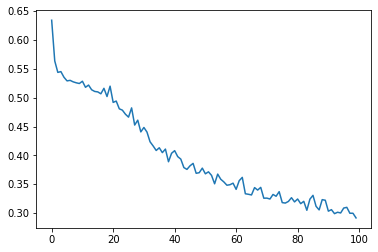

In [ ]:
# Plotted training loss

plt.plot(range(100), epoch_loss_arr)
plt.show()

### Testing using test data and trained model

In [28]:
# Testing a single test sequence and labelling this based on probabilities generated by model.
test_iter = iter(test_loader)
_, im, real_lab = next(test_iter).values()
print(im)
im = im.type(torch.FloatTensor)
outputs_pred = model(im)
print(outputs_pred)

pred_lab = []

outputs_pred = torch.squeeze(outputs_pred)
for val in outputs_pred:
  if val > 0.5:
    pred_lab.append(1)
  else:
    pred_lab.append(0)

print(np.array(pred_lab))

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.]]], dtype=torch.float64)
tensor([[[7.9686e-01, 8.4878e-01, 8.8898e-01, 8.3581e-01, 8.1768e-01,
          8.1467e-01, 7.8606e-01, 7.8799e-01, 8.3301e-01, 8.6333e-01,
          9.1999e-01, 9.2831e-01, 9.2089e-01, 9.3371e-01, 9.4908e-01,
          9.4807e-01, 9.2725e-01, 9.2557e-01, 8.9405e-01, 8.9806e-01,
          9.1498e-01, 8.9225e-01, 8.3980e-01, 7.3481e-01, 7.5613e-01,
          7.6560e-01, 7.1958e-01, 7.8299e-01, 7.6456e-01, 7.4866e-01,
          7.4915e-01, 7.5357e-01, 7.5774e-01, 8.2598e-01, 8.1899e-01,
          8.0277e-01, 8.0951e-01, 8.5550e-01, 8.6194e-01, 8.7729e-01,
          8.3019e-01, 6.8730e-01, 7.8416e-01, 8.4297e-01, 9.1731e-01,
          9.3065e-01, 9.3245e-01, 9.5755e-01, 9.4753e-01, 9.2438e-01,
          9.1285e

Evaluating similarity over entire test dataset.

In [25]:
# Unsure if this check similarity function is correct.
def check_similarity(gen, true):
  gen = torch.squeeze(gen)
  custom_lab = []
  for val in gen:
    if val > 0.5:
      custom_lab.append(1)
    else:
      custom_lab.append(0)
  
  # This checks every amino acid. I could also check if the disorder predictions were correct and what ratio this gives.
  total_pred_right = 0
  for i, value in enumerate(torch.squeeze(true)):
    if value == custom_lab[i]:
      total_pred_right += 1
  
  ratio_right = total_pred_right / len(custom_lab)
  return ratio_right

with torch.no_grad():
  similarity_sum = 0
  for test_seq in test_loader:
    input_seq = test_seq.get('image')
    input_seq = input_seq.type(torch.FloatTensor)
    true_label = test_seq.get('label')

    output_label = model(input_seq)
    similarity_sum += check_similarity(output_label, true_label)

  right_percentage = similarity_sum / len(test_loader)

In [26]:
right_percentage

0.8003953115893218

### Saving model - for later use.

In [ ]:
# Writes trained model to storage

PATH = '/content/drive/My Drive/Colab Notebooks/DL-DISS/cnn_net.pth'
torch.save(model.state_dict(), PATH)

In [29]:
# To reload the model back in, this class was created and instantiated so that the state dictionary of the model could be loaded.

class FCN_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(20, 10, 21, padding=10)
        self.conv2 = nn.Conv1d(10, 10, 21, padding=10)
        self.conv3 = nn.Conv1d(10, 1, 21, padding=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        return x

In [30]:
# Reads trained model from storage
PATH = '/content/drive/My Drive/Colab Notebooks/DL-DISS/cnn_net.pth'

loaded_model = FCN_Net()
loaded_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [31]:
loaded_model

FCN_Net(
  (conv1): Conv1d(20, 10, kernel_size=(21,), stride=(1,), padding=(10,))
  (conv2): Conv1d(10, 10, kernel_size=(21,), stride=(1,), padding=(10,))
  (conv3): Conv1d(10, 1, kernel_size=(21,), stride=(1,), padding=(10,))
)

Testing a single protein sequence. This will be useful to understand the models behaviour when given a single sequence to predict.

In [51]:
def make_single_seq_to_test_loaded_model():
  
  acc, vectorised_image, true_label = formed_dataset_class[0].values()
  vectorised_image = torch.tensor(vectorised_image)
  vectorised_image = vectorised_image.type(torch.FloatTensor)
  true_label = torch.tensor(true_label)
  true_label = true_label.type(torch.FloatTensor)

  with torch.no_grad():
    predicted_label = loaded_model(vectorised_image)

  pred_lab = []
  predicted_label = torch.squeeze(predicted_label)
  for val in predicted_label:
    if val > 0.5:
      pred_lab.append(1)
    else:
      pred_lab.append(0)

  print(np.array(pred_lab))  

In [52]:
make_single_seq_to_test_loaded_model()

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

The file below can be used with an external Python file, then with the Django webapp to ensure the planned process works.

In [58]:
acc, vectorised_image, true_label = formed_dataset_class[0].values()
reusable_test_seq = {'vector_seq' : vectorised_image, 'true_label' : true_label}
with open('/content/drive/My Drive/Colab Notebooks/DL-DISS/singleSeqTest.txt', 'wb') as outfile:
    pickle.dump(reusable_test_seq, outfile)

In [72]:
with open('/content/drive/My Drive/Colab Notebooks/DL-DISS/singleSeqTest.txt', 'rb') as infile:
    single_test_seq_loaded = pickle.load(infile)

seq, lab = single_test_seq_loaded.values()
seq = torch.tensor(seq)
seq = seq.type(torch.FloatTensor)
lab = torch.tensor(lab)
lab = lab.type(torch.FloatTensor)

with torch.no_grad():
    predicted_label = loaded_model(seq)
